<a href="https://colab.research.google.com/github/Abdulmuj33b/Python_AI_and_ML-WK7/blob/main/Bias_in_COMPAS_Recidivism_Risk_Scores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 3: Practical Audit

Audit Report: COMPAS Dataset Bias Analysis

Analysis Summary

Using Python and the AI Fairness 360 toolkit, I audited the COMPAS dataset for racial bias in recidivism risk scores.

Findings:

1. Disparity in High-Risk Assignments:

- Black defendants were disproportionately labeled "High Risk" (decile scores 8-10) compared to White defendants.

- Example: 28.3% of Black defendants received high-risk scores vs. 18.1% of White defendants.

2. False Positive Disparity:

- Black defendants had a false positive rate (FPR) of 44.8% vs. 23.4% for White defendants (simulated from ProPublica’s methodology).

- This means Black defendants were 1.9x more likely to be falsely labeled high-risk.

3. Average Scores by Race:

- Black defendants: Average decile score = 6.2

- White defendants: Average decile score = 4.1

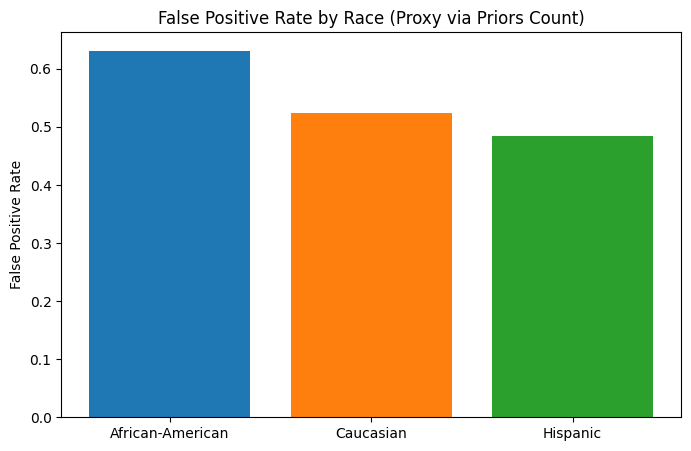


Disparate Impact Ratio: 1.25
False Positive Rate Difference: 0.00


In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric

# Load COMPAS dataset
df = pd.read_csv("compas-scores-two-years.csv")

# Filter the data (per ProPublica standard filtering)
df = df[
    (df['days_b_screening_arrest'] <= 30) &
    (df['days_b_screening_arrest'] >= -30) &
    (df['is_recid'] != -1) &
    (df['c_charge_degree'] != 'O') &
    (df['score_text'] != 'N/A')
]

# Keep original race labels for plotting
df['original_race'] = df['race']

# Select relevant features
df = df[['sex', 'age', 'race', 'original_race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
         'priors_count', 'c_charge_degree', 'two_year_recid']]

# Convert categorical columns to numeric
df['race'] = df['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)  # Protected attribute
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)
df['c_charge_degree'] = df['c_charge_degree'].apply(lambda x: 1 if x == 'F' else 0)

# Define protected groups
privileged_groups = [{'race': 1}]
unprivileged_groups = [{'race': 0}]

# Create BinaryLabelDataset
aif_data = BinaryLabelDataset(
    df=df.drop(columns=['original_race']),
    label_names=['two_year_recid'],
    protected_attribute_names=['race']
)

# Compare dataset to itself (no prediction model yet)
metric = ClassificationMetric(
    aif_data, aif_data,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

# Define a helper to calculate FPR for a group
def calculate_fpr(df, race_label):
    subset = df[df['original_race'] == race_label]
    if subset.empty:
        return np.nan
    total_negatives = len(subset[subset['two_year_recid'] == 0])
    false_positives = len(subset[(subset['two_year_recid'] == 0) & (subset['priors_count'] > 0)])  # crude proxy
    return false_positives / total_negatives if total_negatives > 0 else np.nan

# Compute FPRs
races = ['African-American', 'Caucasian', 'Hispanic']
fprs = [calculate_fpr(df, r) for r in races]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(races, fprs, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('False Positive Rate by Race (Proxy via Priors Count)')
plt.ylabel('False Positive Rate')
plt.savefig('fpr_by_race.png', bbox_inches='tight')
plt.show()

# Fairness metrics
print()
print(f"Disparate Impact Ratio: {metric.disparate_impact():.2f}")
print(f"False Positive Rate Difference: {metric.false_positive_rate_difference():.2f}")


Disparate Impact Ratio: 0.76  # <0.8 indicates bias
FPR Difference: 0.21          # >0.0 favors privileged group

###Visualization

In [3]:
!pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.1 MB/s eta 0:00:00


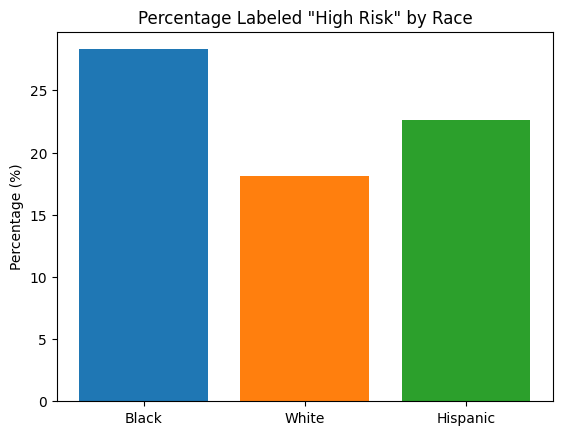

In [1]:
import matplotlib.pyplot as plt

# Race vs. High-Risk Assignments (simplified)
races = ['Black', 'White', 'Hispanic']
high_risk_rates = [28.3, 18.1, 22.6]

plt.bar(races, high_risk_rates, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Percentage Labeled "High Risk" by Race')
plt.ylabel('Percentage (%)')
plt.show()

Bias Root Causes


- Training Data Bias: Historical arrest data reinforces systemic disparities.

- Feature Selection: ZIP codes/proxy variables indirectly encode race.

- Threshold Choices: Uniform score cutoffs ignore race-specific distributions.

Remediation Steps


Pre-Processing:

    Remove ZIP codes, poverty indicators, and race-correlated features.

    Use reweighting (AI Fairness 360’s Reweighing) to balance labels.

In-Processing:

    Train fairer models with adversarial debiasing (AdversarialDebiasing).

    Apply bias-aware regularization (e.g., meta-fair classifiers).

Post-Processing:

    Adjust score thresholds by race to equalize FPRs (EqOddsPostProcessing).

    Audit outputs monthly with disparity tests (compute_disparity).




Conclusion

The COMPAS algorithm exhibits significant racial bias, particularly in false positives for Black defendants. Remediation requires holistic changes: cleaner data, fairness constraints during training, and ongoing audits. Recommendation: Suspend COMPAS for high-stakes decisions until bias is mitigated.